In [106]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy
import logging
import requests
from io import BytesIO

import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18

import matplotlib.pyplot as plt

from furl import furl
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
!pip install furl

In [45]:
# API Template

GALEX_URL = "https://www.legacysurvey.org/viewer/cutout.jpg?ra=0.9514&dec=7.4776&layer=galex&pixscale=1.5&size=200"

HSC_DR2_URL = "https://www.legacysurvey.org/viewer/cutout.jpg?ra=0.9565&dec=2.0675&layer=hsc-dr2&pixscale=0.178&size=200"

UNWISE_URL = "https://www.legacysurvey.org/viewer/cutout.jpg?ra=1.3752&dec=7.2832&layer=unwise-neo7&pixscale=2.75&size=200" 

VLASS_URL = "https://www.legacysurvey.org/viewer/cutout.jpg?ra=1.1209&dec=7.3928&layer=vlass1.2&pixscale=2.00&size=200"

LEGACY_DR9_URL = "https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.0348&dec=27.9783&layer=ls-dr9&pixscale=0.262&size=200"

In [57]:
def update_url(ra, dec, url_template, size_arcsec=15):
    """
    Updates the "ra" and "dec" parameters of a URL template with the provided values.

    Args:
    - ra (float): The new right ascension value in degrees.
    - dec (float): The new declination value in degrees.
    - size_arcsec (float, optional): The size of the cutout image in **arcsec** unit. Default is 15 arcsec.
    - url_template (str): The URL template with placeholders for "ra" and "dec".

    Returns:
    - str: The updated URL with the new "ra" and "dec" parameters.
    """
    # Use the furl library to parse the URL template
    f = furl(url_template)

    # Update the "ra" and "dec" parameters with the new values
    f.args["ra"] = ra
    f.args["dec"] = dec
    
    # Get the pixel size in arcsec and convert the image size into pixel numbers
    f.args["size"] = "{:d}".format(np.floor(size_arcsec / float(f.args["pixscale"])).astype(int))

    # Return the updated URL as a string
    return str(f)

In [58]:
def get_image(ra, dec, template, **kwargs):
    """
    Return the JPG image as a numpy array based on the (RA, Dec) and a URL template.
    
    Args:
    - ra (float): The right ascension value in degrees.
    - dec (float): The declination value in degrees.
    - url_template (str): The URL template.

    Returns:
    - img: The downloaded JPG picture as a numpy array in RGB format.
    """
    # Make a request to the API and get the image content
    try:
        response = requests.get(update_url(ra, dec, template, **kwargs))
        img_content = response.content
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
        return None
    except requests.exceptions.RequestException as err:
        print(f"An error occurred: {err}")
        return None

    # Convert the image content to a numpy array using PIL
    img = Image.open(BytesIO(img_content))
    img = img.convert('RGB')
    
    return img

In [84]:
def prepare_visual_check(name, ra, dec, redshift, size_arcsec=30., use_hsc=False):
    """
    Prepare a mult-panel picture to check the optical, UV, and radio image of the selected region.
    """
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.02, wspace=0.02)

    # Optical picture from HSC or LegacySurvey 
    if use_hsc:
        pic_opt_s = get_image(ra, dec, HSC_DR2_URL, size_arcsec=size_arcsec)
        pic_opt_b = get_image(ra, dec, HSC_DR2_URL, size_arcsec=(size_arcsec * 2.5))
        opt_label = "HSC"
    else:
        pic_opt_s = get_image(ra, dec, LEGACY_DR9_URL, size_arcsec=size_arcsec)
        pic_opt_b = get_image(ra, dec, LEGACY_DR9_URL, size_arcsec=(size_arcsec * 2.5))
        opt_label = "Legacy"

    if pic_opt_s is not None:
        axs[0, 0].imshow(np.asarray(pic_opt_s), origin='lower', interpolation='none')
        axs[0, 0].text(0.05, 0.92, opt_label, fontsize=22, color='w', transform=axs[0, 0].transAxes)

    if pic_opt_b is not None:
        axs[0, 1].imshow(np.asarray(pic_opt_b), origin='lower', interpolation='none')
        axs[0, 1].text(0.05, 0.92, opt_label + " Large", fontsize=22, color='w', transform=axs[0, 1].transAxes)
        # 
        opt_b_w, opt_b_h = pic_opt_b.size
        zoom_box = patches.Rectangle(
            (opt_b_w / 2 - opt_b_w / 5, opt_b_h / 2 - opt_b_h / 5), opt_b_w / 2.5, opt_b_h / 2.5, 
            linewidth=2, linestyle='--', alpha=0.8, edgecolor='orangered', facecolor='none')
        axs[0, 1].add_patch(zoom_box)

    # GALEX UV image 
    pic_uv = get_image(ra, dec, GALEX_URL, size_arcsec=size_arcsec) 

    if pic_uv is not None:
        axs[1, 0].imshow(np.asarray(pic_uv), origin='lower', interpolation='none')
        axs[1, 0].text(0.05, 0.92, "GALEX", fontsize=22, color='w', transform=axs[1, 0].transAxes)

    # VLASS Radio continuum 
    pic_radio = get_image(ra, dec, VLASS_URL, size_arcsec=size_arcsec) 

    if pic_radio is not None:
        axs[1, 1].imshow(np.asarray(pic_radio), origin='lower', interpolation='none')
        axs[1, 1].text(0.05, 0.92, "VLASS", fontsize=22, color='w', transform=axs[1, 1].transAxes)

    # Add titles to the subplots
    title_1 = r"$\rm {:s}$".format(str(name)) + r"$\ \ z={:5.3f}$".format(redshift)
    axs[0, 0].set_title(title_1, fontsize=20)
    title_2 = r"$\rm RA:$" + r"${:8.4f}$".format(ra) + r"$\ \ \rm Dec:$" + r"${:7.4f}$".format(dec) 
    axs[0, 1].set_title(title_2, fontsize=20)

    for ax in axs.flat:
        # Hide tick labels on all subplots
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Turn off the grid lines
        ax.grid(False)

    # Show the plot
    return plt

In [118]:
def kpc_to_arcsec(kpc_scale, redshift):
    """
    Convert scale in Kpc at a given redshift to arcsec based on the Planck18 cosmology model.
    """
    return ((kpc_scale * u.kpc) * Planck18.arcsec_per_kpc_proper(redshift)).value

### Sample 1: redMaPPer clusters in DES

In [121]:
des_file = '/Users/shuang/work/des/redmapper_y1a1/redmapper_y1a1_public_v6.4_catalog.fits.gz'

des_cat = Table.read(des_file)

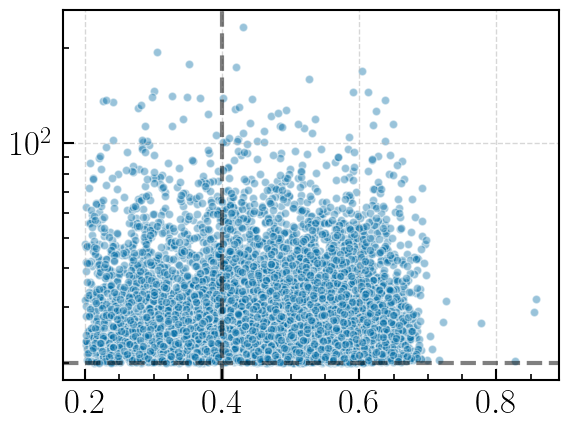

In [144]:
plt.scatter(des_cat['Z_LAMBDA'], des_cat['LAMBDA'], alpha=0.4, edgecolor='w')
plt.axvline(0.40, c='k', linestyle='--', linewidth=3, alpha=0.5)
plt.axhline(20, c='k', linestyle='--', linewidth=3, alpha=0.5)
plt.yscale('log')

In [133]:
des_redm_mask_1 = (des_cat['Z_LAMBDA'] <= 0.4)
print(des_redm_mask_1.sum())

2051


In [138]:
des_redm_mask_2 = (des_cat['Z_LAMBDA'] <= 0.4) & (des_cat['P_CEN'][:, 0] > 0.6)
print(des_redm_mask_2.sum())

1721


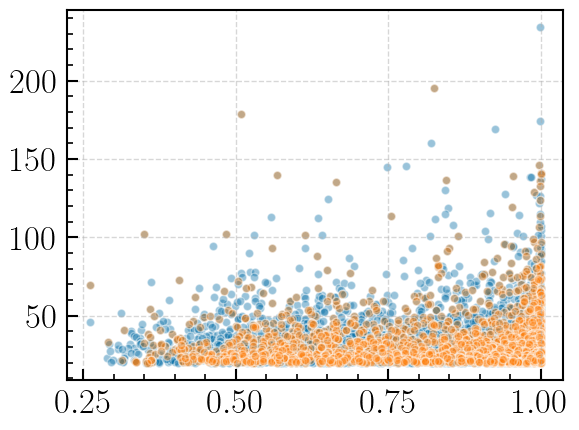

In [134]:
plt.scatter(des_cat['P_CEN'][:, 0], des_cat['LAMBDA'], alpha=0.4, edgecolor='w')
plt.scatter(des_cat['P_CEN'][:, 0][des_redm_mask_1], des_cat['LAMBDA'][des_redm_mask_1], alpha=0.4, edgecolor='w')

HTTP error occurred: 500 Server Error: Internal Server Error for url: https://www.legacysurvey.org/viewer/cutout.jpg?ra=43.564574&dec=-58.95297&layer=vlass1.2&pixscale=2.00&size=17


<module 'matplotlib.pyplot' from '/Users/shuang/miniconda3/envs/py10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

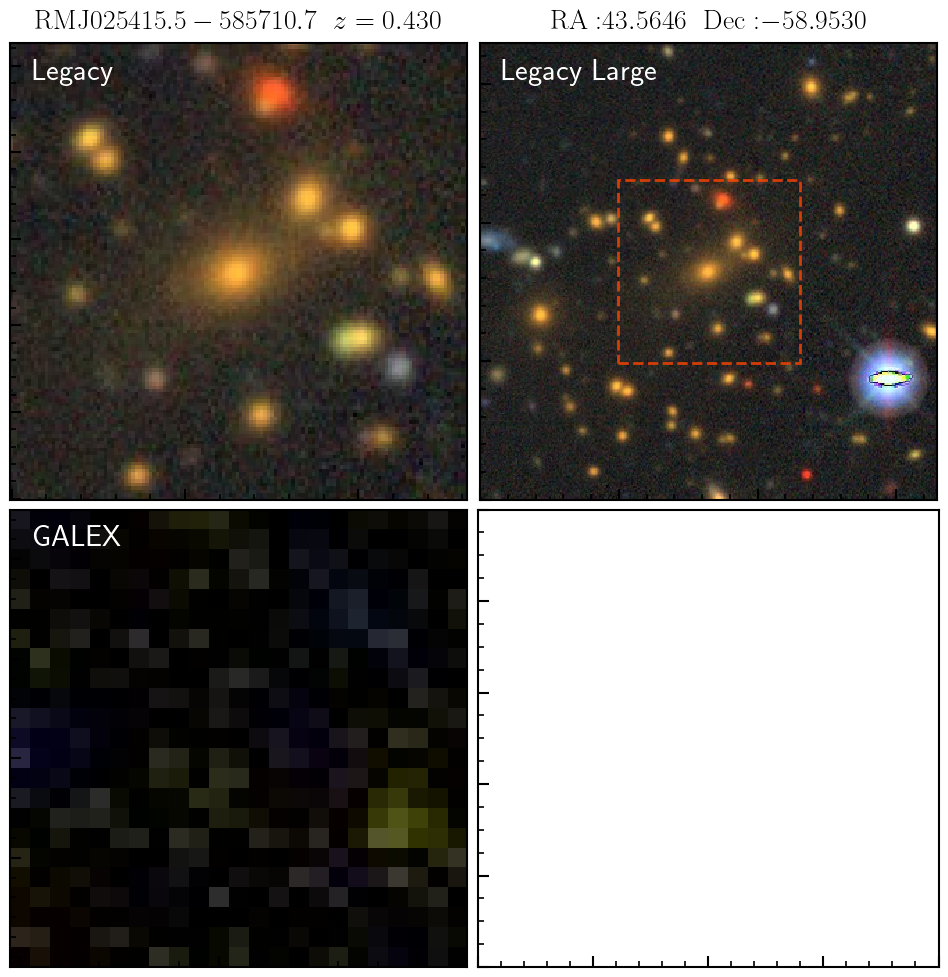

In [141]:
# Test 
cluster = des_cat[0]

prepare_visual_check(cluster['NAME'], cluster['RA'], cluster['DEC'], cluster['Z_LAMBDA'], size_arcsec=kpc_to_arcsec(200., cluster['Z_LAMBDA']), use_hsc=False)


### Sample 2: HSC Massive Galaxies

In [153]:
hsc_file = '/Users/shuang/Dropbox/work/data/topn/s16a_massive_z_0.5_logm_11.4_decals_full_fdfc_bsm_ell.fits'

hsc_cat = Table.read(hsc_file)
hsc_cat.sort('logm_max')
hsc_cat.reverse()

len(hsc_cat)

2171

In [154]:
hsc_cat[0]

index,id_s16a,ra,dec,clean_photometry,z_spec,z_best,z_phot,z_type,gcmodel_mag,gcmodel_mag_err,rcmodel_mag,rcmodel_mag_err,icmodel_mag,icmodel_mag_err,zcmodel_mag,zcmodel_mag_err,ycmodel_mag,ycmodel_mag_err,MSTAR,lum_max,lum_150,lum_120,lum_100,lum_75,lum_50,lum_25,lum_10,lum_5,lum_15,lum_30,lum_40,lum_60,logm_5,logm_10,logm_15,logm_25,logm_30,logm_40,logm_50,logm_60,logm_75,logm_100,logm_120,logm_150,logm_max,photoz_err68_min,photoz_err68_max,vdisp_sdss,vdisp_err_sdss,gama_id,fluxscale_gama,logms_gama,logms_err_gama,id_cluster_redm,p_mem_redm,z_lambda_redm,z_lambda_err_redm,lambda_redm,lambda_err_redm,p_cen_1_redm,id_camira,z_camira,n_cor_camira,logms_camira,id_mem_camira,w_mem_camira,SFR,AV,TAU,AGE,ZMETAL,r20_max,r50_max,r80_max,r90_max,r20_120,r50_120,r80_120,r90_120,r20_100,r50_100,r80_100,r90_100,c82_max,c82_120,c82_100,logmh_vir_forest,logmh_vir_plane,logmh_vir_symbol,logr_vir_forest,old_dir,old_index,new_dir,is_ell,mean_e,mean_pa
int64,int64,float64,float64,bool,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes30,int64,bytes41,bool,float64,float64
886,43118873196650777,137.01381690841953,2.0122612294944684,True,0.46825000643730164,0.46825000643730164,--,3,20.691757,0.003787134,19.009737,0.0012884492,18.040285,0.0007317609,17.655472,0.00092147716,17.396336,0.0011237009,11.969206809997559,11.74633502960205,11.697701182614976,11.672225162098686,11.646471372258578,11.600602513746056,11.518791450302537,11.331516766401018,11.027242626769098,10.713916072964045,11.17285867337155,11.38365470781669,11.462237840625148,11.558299492938781,11.228828700788728,11.542155254593782,11.687771301196234,11.846429394225702,11.898567335641374,11.977150468449832,12.03370407812722,12.073212120763465,12.11551514157074,12.161384000083261,12.18713778992337,12.21261381043966,12.261247657426734,0.39727542,0.5209538,347.78900146484375,47.171173095703125,382494,2.4960745757273504,12.05483352541231,0.17033398607821462,35229,1.0,0.45916032791137695,0.012977680191397667,37.272117614746094,6.03383731842041,0.9999542236328125,1777,0.4555000066757202,32.97700119018555,12.531000137329102,1777,1.0,-2.794536590576172,0.022038903087377548,0.1685338169336319,8.297603607177734,0.018881015479564667,10.54069322016156,37.61370656266157,101.89595758101534,101.89595758101534,8.71445641678906,28.700603029190987,65.48489061051858,65.48489061051858,8.188056982613475,26.19832635055257,57.49426040082717,57.49426040082717,9.666912360765354,7.514512377887044,7.021722067019138,14.724143171155594,14.965407361958581,14.987795452048868,3.1973666118944717,./z0405/HDF5/HSC-z0405-1050.h5,1050,./neosbp/nz0405/HDF5/HSC-nz0405-0886.HDF5,True,0.31,29.4


In [147]:
hsc_massive_mask_1 = (hsc_cat['z_best'] <= 0.4) & (hsc_cat['dec'] <= 5.0)
print(hsc_massive_mask_1.sum())

1239


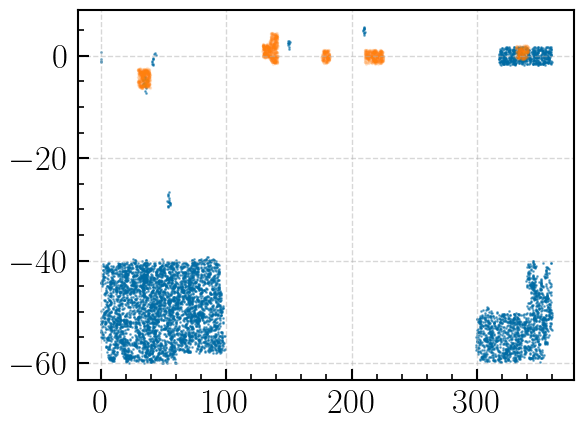

In [152]:
plt.scatter(des_cat['RA'], des_cat['DEC'], s=1, alpha=0.5)
plt.scatter(hsc_cat['ra'], hsc_cat['dec'], s=2, alpha=0.1)

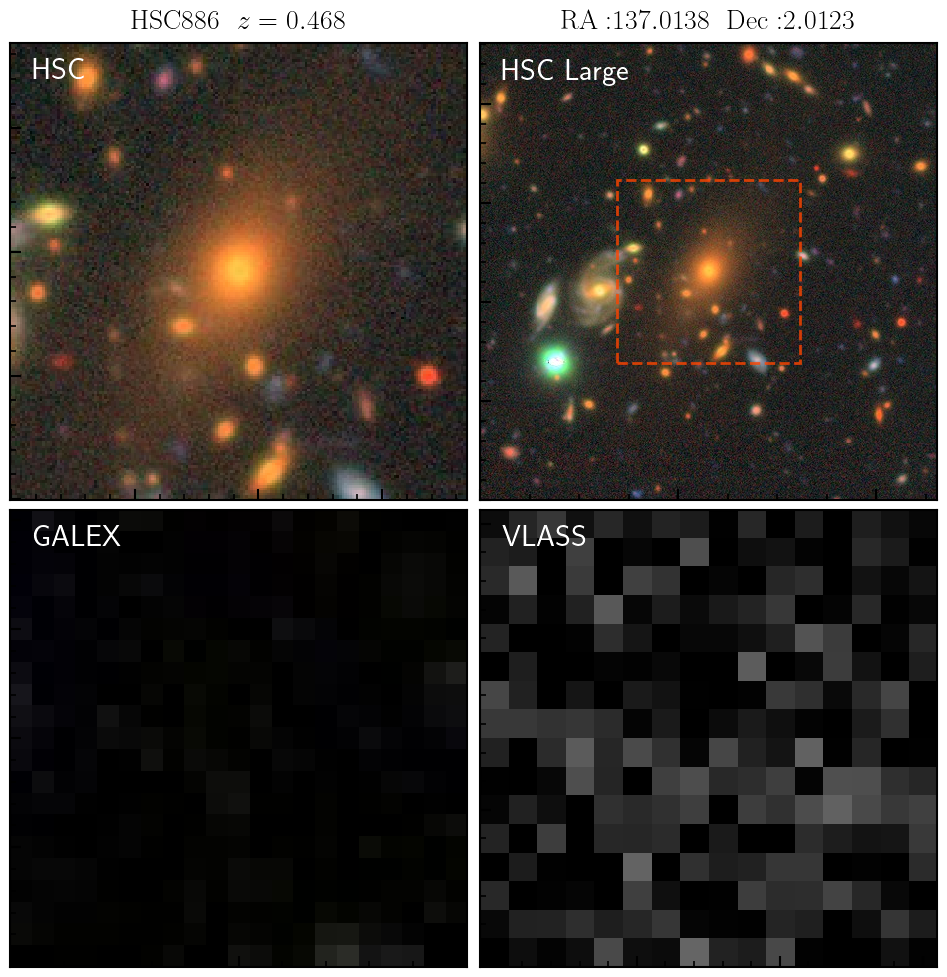

In [158]:
# Test 
massive = hsc_cat[0]

png_name = "hsc_{:d}.png".format(massive['index'])

fig = prepare_visual_check("HSC {:d}".format(massive['index']), massive['ra'], massive['dec'], massive['z_best'], 
                           size_arcsec=kpc_to_arcsec(200., massive['z_best']), use_hsc=True)

fig.savefig(png_name, dpi=200)

#### Explore the inner v.s. outskirt stellar mass plane

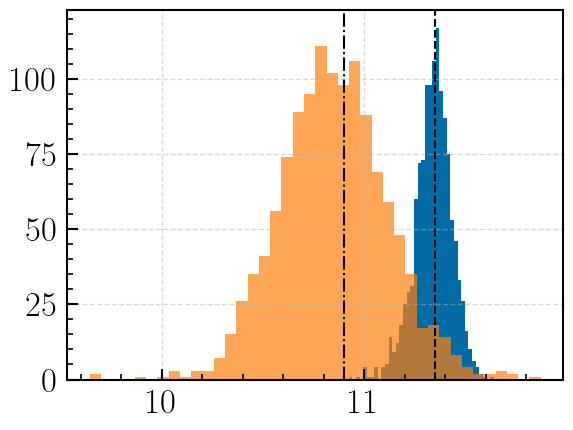

In [204]:
plt.hist(hsc_cat['logm_10'][hsc_massive_mask_1], bins=40)
plt.hist(np.log10(10.0 ** hsc_cat['logm_max'] - 10.0 ** hsc_cat['logm_50'])[hsc_massive_mask_1] , bins=40, alpha=0.7)
plt.axvline(11.35, linestyle='--', color='k')
plt.axvline(10.90, linestyle='-.', color='k')

In [190]:
hsc_massive_mask_2 = (hsc_cat['z_best'] <= 0.35) & (hsc_cat['dec'] <= 5.0) & (hsc_cat['logm_10'] >= 11.35) & (hsc_cat['z_spec'] > 0.) & (hsc_cat['vdisp_sdss'] >= 100.0)
print(hsc_massive_mask_2.sum())

371


In [196]:
X = hsc_cat['logm_10'][hsc_massive_mask_2]
Y = np.log10(10.0 ** hsc_cat['logm_max'] - 10.0 ** hsc_cat['logm_50'])[hsc_massive_mask_2] 

# Perform linear regression
slope, intercept = np.polyfit(X, Y, 1)

# Calculate predicted Y values based on the best-fit line
Y_pred = slope * X + intercept

# Calculate residuals and their standard deviation (1-sigma scatter)
residuals = Y - Y_pred
scatter = np.std(residuals)

# Identify targets at least 1 sigma above and below the best-fit relation
above = Y > Y_pred + scatter
below = Y < Y_pred - scatter


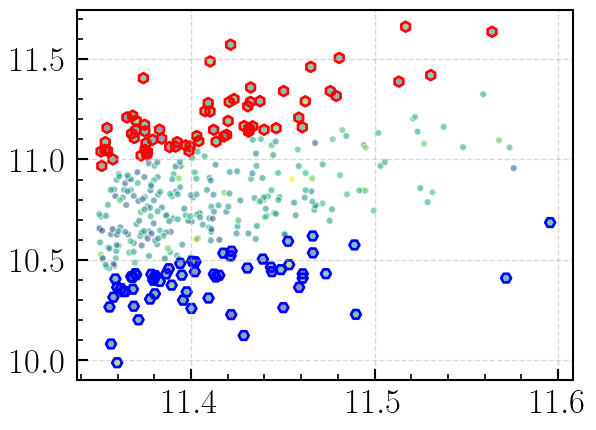

In [198]:
plt.scatter(X, Y, s=25, alpha=0.6, edgecolor='w', c=np.log10(hsc_cat['vdisp_sdss'][hsc_massive_mask_2]))

plt.scatter(X[above], Y[above], s=50, marker='h', facecolor='none', edgecolor='r', linewidth=2)
plt.scatter(X[below], Y[below], s=50, marker='H', facecolor='none', edgecolor='b', linewidth=2)

In [209]:
above_cat = hsc_cat[hsc_massive_mask_2][above]['index', 'ra', 'dec']
below_cat = hsc_cat[hsc_massive_mask_2][below]['index', 'ra', 'dec']

In [213]:
below_cat.pprint_all()

index         ra                  dec         
----- ------------------ ---------------------
 2054  336.6930157985794    0.8877946872980044
  887  137.0361146231708     3.437157973842145
 1860  225.1198839259114   -0.7214351027438111
   39 30.547059749720333    -3.779219841075224
  137  32.54753760072463   -3.7027336779664894
  302  35.51803342624742   -3.6720183967718403
 1473 213.61569359160288     1.056724826160493
  291 35.303485767417314   -3.1988955737433944
  757 134.90765326822952    2.8878505305065474
 1182 176.57150133870428   -0.7576067118162616
 1873  331.6405000422841    1.4824726886595676
 1983  335.0192399196231    1.1865138429407318
 1543 216.50490728747312  -0.24660978079391457
  686  133.1493794150089    1.7075011311314114
 1575  217.3076274162511   -0.6698475394159573
 1799 223.49081852326054   -0.5558871985952184
 1723  221.0494621904363  -0.11396868883648188
  731 134.22852955884127    0.8892681196763927
 1811 223.65326813729612    0.2896251650451999
  128  32.432